<a href="https://colab.research.google.com/github/KhaledGhaleb/PatternRecognition/blob/main/Exam_Q2_ClearEpoch_Ouput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Question 2
```
For the COREL dataset: (15 marks)
Use 50 images for training and 50 for testing for each class.
```

In [ ]:
import requests, zipfile, os, io, time
zip_file_url = 'https://www.dropbox.com/sh/6otniml0u3g4ovy/AAAs9Abejlh78S9dsV3DEf_na?dl=1'
r = requests.get(zip_file_url, stream=True)
z = zipfile.ZipFile(io.BytesIO(r.content))
path_to_dir =  os.getcwd();
#print(path_to_dir)
PATH = os.path.join(path_to_dir, 'Corel')
z.extractall(PATH)
print(PATH)

/content/Corel


Prepare Train and Validation data:

* Set ratio of 0.5 validation
* Set Image size to 100*100 * 3


In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
BATCH_SIZE = 500
IMG_SIZE = (256, 256)
COLOR_MODE = 'rgb' #"grayscale"  #  "rgb"
Color_Num = 3
Valid_ratio = 0.5

train_dataset = image_dataset_from_directory(PATH,
                                             seed = 1234,                                           
                                             color_mode = COLOR_MODE, 
                                             validation_split = Valid_ratio,
                                             subset = "training",
                                             image_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode ='categorical',
                                             )
Validation_dataset = image_dataset_from_directory(PATH,
                                             seed = 1234,                                           
                                             color_mode = COLOR_MODE, 
                                             validation_split = Valid_ratio,
                                             subset = 'validation',
                                             image_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode ='categorical',
                                             )
train_dataset_gray = image_dataset_from_directory(PATH,
                                             seed = 1234,                                           
                                             color_mode = "grayscale", 
                                             validation_split = Valid_ratio,
                                             subset = "training",
                                             image_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode ='categorical',
                                             )
Validation_dataset_gray = image_dataset_from_directory(PATH,
                                             seed = 1234,                                           
                                             color_mode = "grayscale", 
                                             validation_split = Valid_ratio,
                                             subset = 'validation',
                                             image_size=IMG_SIZE,
                                             batch_size=BATCH_SIZE,
                                             label_mode ='categorical',
                                             )

Found 1000 files belonging to 10 classes.
Using 500 files for training.
Found 1000 files belonging to 10 classes.
Using 500 files for validation.
Found 1000 files belonging to 10 classes.
Using 500 files for training.
Found 1000 files belonging to 10 classes.
Using 500 files for validation.


Normalize data set

In [ ]:
import tensorflow as tf
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_normalized_ds = train_dataset.map(lambda x, y: (normalization_layer(x), y))
train_normalized_ds_gray = train_dataset_gray.map(lambda x, y: (normalization_layer(x), y))
validation_normalized_ds = Validation_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_normalized_ds_gray = Validation_dataset_gray.map(lambda x, y: (normalization_layer(x), y))

Convert normalized dataset to images and labels in nparray 

In [ ]:
train_images,train_labels = list(train_normalized_ds.as_numpy_iterator())[0]
validate_images,validate_labels  = list(validation_normalized_ds.as_numpy_iterator())[0]
train_images_gray,_ = list(train_normalized_ds_gray.as_numpy_iterator())[0]
validate_images_gray,_  = list(validation_normalized_ds_gray.as_numpy_iterator())[0]
train_images_gray.shape

(500, 256, 256, 1)

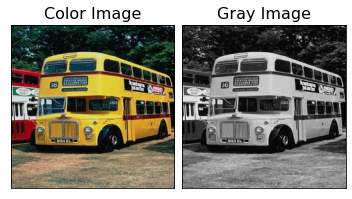

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(train_images[0])
ax[0].set_title('Color Image', size=16)
ax[1].imshow(train_images_gray[0,:,:,0],cmap='gray')
ax[1].set_title( 'Gray Image', size=16);

#Q2.a
```
Try at least 10 experiments with CNN (different CNN topology, different filter sizes, different pooling, different number of epochs, etc.). 
Which one gave the best results and why in your opinion? 
(include 1 experiment with the Gray images and the rest with the color images).
```

#Q2.a.1 (CNN Example 1 "Color")
* use 3 conv layer with 5 * 5 filters
* max pool after each conv layer
* Epochs is 50
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_1 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(5, kernel_size=(5, 5), strides=1, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(12, kernel_size=(5, 5), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 5)       380       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 12)      1512      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 12)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        6976      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

Compile and Fit CNN

In [ ]:
Start_time_A1 = time.time()
CNN_model_1.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_1.fit(x= train_images, y= train_labels,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A1 = time.time()

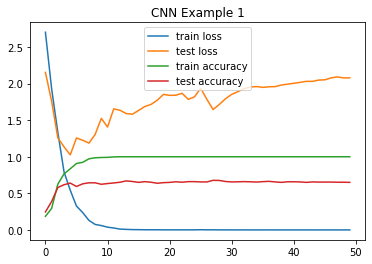

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.title("CNN Example 1")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_1.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_1.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A1 - Start_time_A1, " Sec")

Accuracy: Train: 1.000, Test: 0.650
Loss: Train: 0.000, Test: 2.079
Elapsed time  41.741318225860596  Sec


#Q2.a.1  (CNN Example 1 conclusion)
CNN model have good test accuracy but it is reach the saturation after 15 epoc from 50 epocs run

#Q2.a.2 (CNN Example 2 "Color")
* use 3 conv layer with 5 * 5 filters (10,24,128) filter respectivley in each layer
* max pool after each conv layer
* 0 Dense layer
* Epochs is 50
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()

CNN_model_2 = keras.Sequential(
    [
        #keras.Input(shape=((IMG_SIZE[0],IMG_SIZE[1],3))),
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(10, kernel_size=(5, 5), strides=1, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(5, 5), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(5, 5), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 10)      760       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 24)      6024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       76928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

Compile and Fit CNN

In [ ]:
Start_time_A2 = time.time()
CNN_model_2.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_2.fit(x= train_images, y= train_labels,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A2 = time.time()

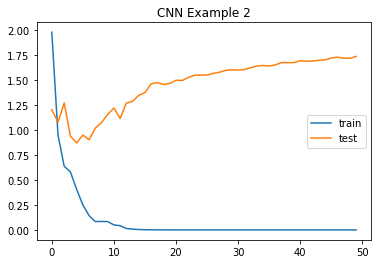

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 2")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_2.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_2.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))

print("Elapsed time ", End_time_A2 - Start_time_A2, " Sec")

Accuracy: Train: 1.000, Test: 0.728
Loss: Train: 0.000, Test: 1.736
Elapsed time  64.0714750289917  Sec


#Q2.a.2  (CNN Example 2 conclusion)
After increase num of filter in each conv layer, final accuracy have better value

#Q2.a.3 (CNN Example 3 "Color")
* use 3 conv layer with 5 * 5 filters (10,24,128) filter respectivley in each layer
* max pool after each conv layer
* 0 Dense layer
* Epochs is 18 (Only Changed)
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_3 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(10, kernel_size=(5, 5), strides=1, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(5, 5), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(5, 5), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 10)      760       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 24)      6024      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       76928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

Compile and Fit CNN

In [ ]:
Start_time_A3 = time.time()
CNN_model_3.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_3.fit(x= train_images, y= train_labels,
                epochs=18,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A3 = time.time()

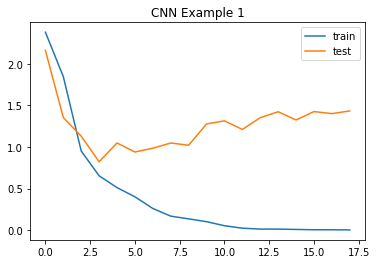

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 3")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_3.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_3.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A3 - Start_time_A3, " Sec")

Accuracy: Train: 1.000, Test: 0.722
Loss: Train: 0.001, Test: 1.434
Elapsed time  41.71855044364929  Sec


#Q2.a.3  (CNN Example 3 conclusion)
After increase num of filter in each layer and remove dense layer still we have overfitting, but final accuracy increased, also by decreasing number of epocs time  elapsed enhanced  30%

#Q2.a.4 (CNN Example 4 "Color")
* use 3 convolusion layer with 3 * 3 filters
* max pool after each conv layer
* Epochs is 18
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_4 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(10, kernel_size=(3, 3), strides=1, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_4.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 10)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 24)      2184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       27776     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0

Compile and Fit CNN

In [ ]:
Start_time_A4 = time.time()
CNN_model_4.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_4.fit(x= train_images, y= train_labels,
                epochs=18,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A4 = time.time()

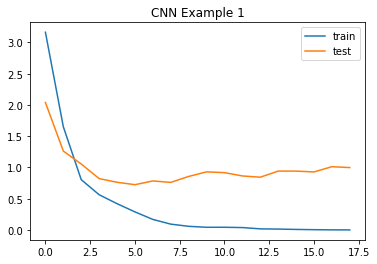

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 4")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_4.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_4.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A4 - Start_time_A4, " Sec")

Accuracy: Train: 1.000, Test: 0.750
Loss: Train: 0.002, Test: 0.999
Elapsed time  41.735304832458496  Sec


#Q2.a.4  (CNN Example 4 conclusion)
Accuracy of validation is enhanced and validation loss ehanced by decreasing filter size.

#Q2.a.5 (CNN Example 5 "Color")
* use 3 convolusion layer with 3 * 3 filters
* strides is 2
* max pool after each conv layer
* Epochs is 50
* dropout 0.5


In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_5 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(10, kernel_size=(3, 3), strides=2, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        2184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         27776     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

Compile and Fit CNN

In [ ]:
Start_time_A5 = time.time()
CNN_model_5.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_5.fit(x= train_images, y= train_labels,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A5 = time.time()

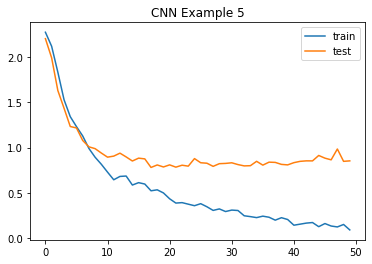

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 5")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_5.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_5.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A5 - Start_time_A5, " Sec")

Accuracy: Train: 0.998, Test: 0.754
Loss: Train: 0.048, Test: 0.854
Elapsed time  41.78561615943909  Sec


#Q2.a.5  (CNN Example 5 conclusion)
By increase the stride we need more epocs but accuracy is still good over 0.7  and validation loss enhanced  

#Q2.a.6 (CNN Example 6 "Color")
* use 6 convolution layer with 5 * 5 and 3 * 3 filters
* strides is 1
* max pool after 2 conv layer
* Epochs is 50
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_6 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(5, kernel_size=(5, 5), strides=1, padding="same",activation="relu"),
        layers.Conv2D(10, kernel_size=(3, 3), strides=2, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(12, kernel_size=(5, 5), strides=1, padding="same", activation="relu"),
        layers.Conv2D(24, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(64, kernel_size=(5, 5), strides=1, padding="same", activation="relu"),
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 5)       380       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 10)      460       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 12)        3012      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 24)        2616      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        3

Compile and Fit CNN

In [ ]:
Start_time_A6 = time.time()
CNN_model_6.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_6.fit(x= train_images, y= train_labels,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A6 = time.time()

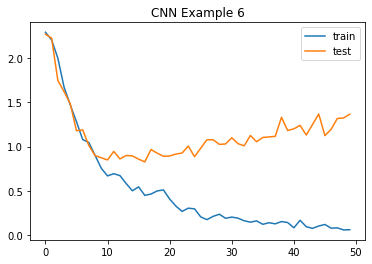

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 6")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_6.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_6.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A6 - Start_time_A6, " Sec")

Accuracy: Train: 0.998, Test: 0.704
Loss: Train: 0.027, Test: 1.367
Elapsed time  40.53667950630188  Sec


#Q2.a.6  (CNN Example 6 conclusion)
by distribute 2 convolution layers after each  then max pooling and repeat, didnot enhance than before bu it make it worse

#Q2.a.7 (CNN Example 7 "Color")
* use 6 convolution layer with  3 * 3 filters
* strides is 2
* max pool after each conv  layer
* Epochs is 50
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_7 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(5, kernel_size=(3, 3), strides=1, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(15, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(45, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(135, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(200, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(300, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_7.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 5)       140       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 5)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 15)      690       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 15)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 45)        6120      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 45)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 135)       5

Compile and Fit CNN

In [ ]:
Start_time_A7 = time.time()
CNN_model_7.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_7.fit(x= train_images, y= train_labels,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A7 = time.time()

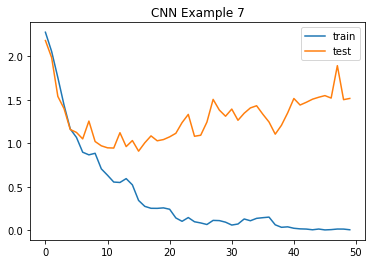

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 7")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_7.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_7.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A7 - Start_time_A7, " Sec")

Accuracy: Train: 1.000, Test: 0.742
Loss: Train: 0.002, Test: 1.517
Elapsed time  44.98398184776306  Sec


#Q2.a.7  (CNN Example 7 conclusion)
By add 3 Convolution and Pooling layers to become total 6 layers, butu still accuracy is good and validation loss is little worse

#Q2.a.8 (CNN Example 8 "Color")
* use 3 convolution layer with  3 * 3 filters
* strides is 2
* max pool after 1 convolution layer
* Epochs is 100
* dropout 0.75

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()

CNN_model_8 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(10, kernel_size=(3, 3), strides=2, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.75),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        2184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         27776     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

Compile and Fit CNN

In [ ]:
Start_time_A8 = time.time()

CNN_model_8.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_8.fit(x= train_images, y= train_labels,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A8 = time.time()

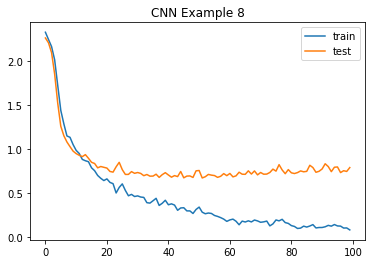

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 8")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_8.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_8.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A8 - Start_time_A8, " Sec")

Accuracy: Train: 1.000, Test: 0.788
Loss: Train: 0.021, Test: 0.787
Elapsed time  53.33641171455383  Sec


#Q2.a.8  (CNN Example 8 conclusion)
By increasing dropout, Validation accuracy enhanced but we need more epocs to get accepted train loss and validation loss.

#Q2.a.9 (CNN Example 9 "Color")
* use 3 convolution layer with  3 * 3 filters
* strides is 2
* max pool after 1 convolution layer
* Epochs is 150
* dropout 0.75
* Minibatch form 50 to 150

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()
CNN_model_9 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],3))),
        layers.Conv2D(10, kernel_size=(3, 3), strides=2, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.75),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_9.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        2184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         27776     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

Compile and Fit CNN

In [ ]:
Start_time_A9 = time.time()
CNN_model_9.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_9.fit(x= train_images, y= train_labels,
                epochs=150,
                batch_size=150,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_A9 = time.time()

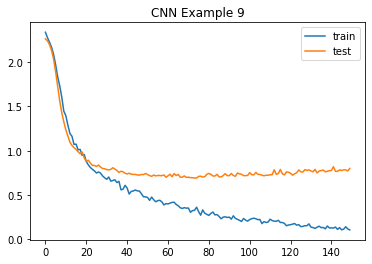

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 9")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_9.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = CNN_model_9.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A9 - Start_time_A9, " Sec")

Accuracy: Train: 0.998, Test: 0.782
Loss: Train: 0.035, Test: 0.800
Elapsed time  67.99698042869568  Sec


#Q2.a.9  (CNN Example 9 conclusion)
Increasing Mini batch from 50 to 150 does not enhance the result from example 8, but take more epocs to reach the same results such that fitting time is increase only

#Q2.a.10 (CNN Example 10 "Gray")
* use 3 convolusion layer with 5 * 5 filters
* max pool after each class
* Epochs is 50
* dropout 0.5

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.regularizers import l1,l2
keras.backend.clear_session()

CNN_model_10 = keras.Sequential(
    [
        keras.layers.InputLayer(((IMG_SIZE[0],IMG_SIZE[1],1))),
        layers.Conv2D(10, kernel_size=(3, 3), strides=2, padding="same",activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(24, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Conv2D(128, kernel_size=(3, 3), strides=2, padding="same", activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        layers.Flatten(),
        layers.Dropout(0.75),
        layers.Dense(10, activation="softmax"),
    ]
)

CNN_model_10.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 10)      100       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 10)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 24)        2184      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 24)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         27776     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0

Compile and Fit CNN

In [ ]:
Start_time_A10 = time.time()
CNN_model_10.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = CNN_model_10.fit(x= train_images_gray, y= train_labels,
                epochs=100,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images_gray,validate_labels))
End_time_A10 = time.time()

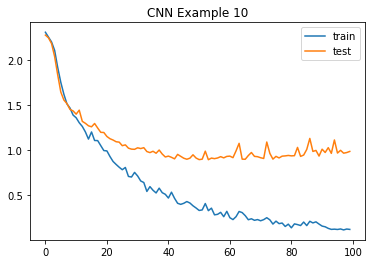

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.title("CNN Example 10")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = CNN_model_10.evaluate(train_images_gray, train_labels, verbose=0)
test_loss, test_acc = CNN_model_10.evaluate(validate_images_gray, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_A10 - Start_time_A10, " Sec")

Accuracy: Train: 1.000, Test: 0.712
Loss: Train: 0.022, Test: 0.989
Elapsed time  41.743088245391846  Sec


#Q2.a.10  (CNN Example 10 conclusion)
Train the Gray model with model layers like example 8, the output validation accuracy is less than that of example 8, such that features maps of gray model loss some information while conversion.

---

#Q2.b (Transfer Learning InceptionV3)
*   Use a pre-trained deep model of your choice, 
* add the required output layers for the COREL classification and 
* fine-tune the model using the COREL training data.
* Then test on the COREL test images.


Transfer learning using InceptionV3
* Get InceptionV3 model from Keras and adjust input shape to be the dimension of Corel Dataset. 
* Add Max pool at the end of the model to get the 2 dimension array at the output
* Freeze the model

In [ ]:
from tensorflow.keras.applications.inception_v3  import InceptionV3
dim = train_images.shape
print(dim)
model_InceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape= (dim[1],dim[2],dim[3]),pooling= 'max')
model_InceptionV3.trainable = False #freeze the model
#model_InceptionV3.summary()

(500, 256, 256, 3)


*Create* New Model

In [ ]:
import keras
from keras import layers
Transfer_model = keras.Sequential(
    [
        keras.layers.InputLayer(((dim[1],dim[2],dim[3]))),
        model_InceptionV3,
        #layers.Dense(64,activation='relu'),
        layers.Dropout(0.75),
        layers.Dense(10, activation="softmax"),
    ]
)

Transfer_model.summary()
for i, layer in enumerate(Transfer_model.layers):
   print(i, layer.name)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_4 (ModuleWrap (None, 2048)              21802784  
_________________________________________________________________
dropout_5 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                20490     
Total params: 21,823,274
Trainable params: 20,490
Non-trainable params: 21,802,784
_________________________________________________________________
0 module_wrapper_4
1 dropout_5
2 dense_8


Compile and fit freezed model

In [ ]:
Start_time_B1 = time.time()
Transfer_model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = Transfer_model.fit(x= train_images, y= train_labels,
                epochs=50,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_B1 = time.time()

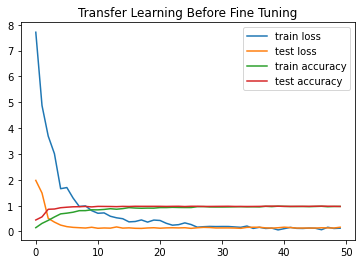

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.title("Transfer Learning Before Fine Tuning")
plt.show()

Fine Tune the model by unfreeze the the InceptionV3 and make low learning curve 

In [ ]:
model_InceptionV3.trainable = True #unfreeze the model

Start_time_B2 = time.time()
Transfer_model.compile(optimizer=keras.optimizers.Adam(1e-5),  # Very low learning rate
    loss="categorical_crossentropy", metrics=["accuracy"])

historyB2 = Transfer_model.fit(x= train_images, y= train_labels,
                epochs=10,
                batch_size=50,
                shuffle=True,
                validation_data=(validate_images,validate_labels))
End_time_B2 = time.time()

Epoch 1/10
10/10 [==============================] - 14s 787ms/step - loss: 1.5941 - accuracy: 0.7147 - val_loss: 0.1627 - val_accuracy: 0.9720
Epoch 2/10
10/10 [==============================] - 6s 654ms/step - loss: 0.8064 - accuracy: 0.8361 - val_loss: 0.1595 - val_accuracy: 0.9740
Epoch 3/10
10/10 [==============================] - 6s 661ms/step - loss: 0.6834 - accuracy: 0.8431 - val_loss: 0.1582 - val_accuracy: 0.9700
Epoch 4/10
10/10 [==============================] - 6s 666ms/step - loss: 0.5541 - accuracy: 0.8832 - val_loss: 0.1562 - val_accuracy: 0.9720
Epoch 5/10
10/10 [==============================] - 8s 791ms/step - loss: 0.3812 - accuracy: 0.9018 - val_loss: 0.1541 - val_accuracy: 0.9720
Epoch 6/10
10/10 [==============================] - 8s 789ms/step - loss: 0.4352 - accuracy: 0.8886 - val_loss: 0.1519 - val_accuracy: 0.9720
Epoch 7/10
10/10 [==============================] - 6s 662ms/step - loss: 0.2388 - accuracy: 0.9457 - val_loss: 0.1513 - val_accuracy: 0.9720
Epoch

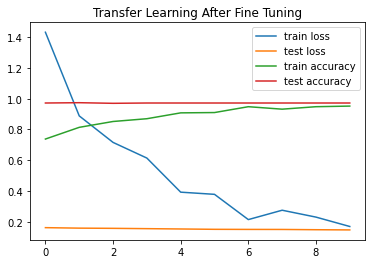

In [ ]:
# plot training history
plt.plot(historyB2.history['loss'], label='train loss')
plt.plot(historyB2.history['val_loss'], label='test loss')
plt.plot(historyB2.history['accuracy'], label='train accuracy')
plt.plot(historyB2.history['val_accuracy'], label='test accuracy')
plt.legend()
plt.title("Transfer Learning After Fine Tuning")
plt.show()

In [ ]:
# evaluate the model
train_loss, train_acc = Transfer_model.evaluate(train_images, train_labels, verbose=0)
test_loss, test_acc = Transfer_model.evaluate(validate_images, validate_labels, verbose=0)
print('Accuracy: Train: %.3f, Test: %.3f' % (train_acc, test_acc))
print('Loss: Train: %.3f, Test: %.3f' % (train_loss, test_loss))
print("Elapsed time ", End_time_B2 - Start_time_B2 + End_time_B1 - Start_time_B1 , " Sec")

Accuracy: Train: 1.000, Test: 0.972
Loss: Train: 0.000, Test: 0.148
Elapsed time  283.1667160987854  Sec


#Q2.b (Transfer Learning Conclusion)

> By using tranfer learning it consume much more time compared to CNN but have better Test accuracy and lower Loss



---



#Q2.c (feature extraction)
* Use a pre-trained deep model of your choice as a feature extractor for the COREL data.
*  Then, train a random forest using the extracted features.
* Then test on the COREL test data.

In [ ]:
from tensorflow.keras.applications.inception_v3  import InceptionV3
dim = train_images.shape
print(dim)
model_InceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape= (dim[1],dim[2],dim[3]),pooling= 'max')
model_InceptionV3.trainable = False #freeze the model

(500, 256, 256, 3)


In [ ]:
import tensorflow as tf
start_time_Q2c = time.time()
#x_train_InceptionV3 = tf.keras.applications.inception_v3.preprocess_input(train_images)
#x_test_InceptionV3 = tf.keras.applications.inception_v3.preprocess_input(validate_images)
TrainFeaturesArr_InceptionV3 = model_InceptionV3.predict(train_images)
ValidateFeaturesArr_InceptionV3 = model_InceptionV3.predict(validate_images)
print(TrainFeaturesArr_InceptionV3.shape,ValidateFeaturesArr_InceptionV3.shape)

(500, 2048) (500, 2048)


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RadomForestFeature  = RandomForestClassifier(max_depth = 20, criterion= 'gini', n_estimators = 100, min_samples_split = 2)
RadomForestFeature.fit(TrainFeaturesArr_InceptionV3,train_labels)
ValidateLabelPredicted = RadomForestFeature.predict(ValidateFeaturesArr_InceptionV3)
TrainLabelPredicted = RadomForestFeature.predict(TrainFeaturesArr_InceptionV3)
end_time_Q2c = time.time()

test on the COREL test data.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('Accuracy for Random Forest')
print('Train Validate Accuracy score: ',accuracy_score(TrainLabelPredicted, train_labels))
print('Validate Validate Accuracy score: ',accuracy_score(ValidateLabelPredicted, validate_labels))
print('Validate F1 Score: ',f1_score(ValidateLabelPredicted, validate_labels, average="macro"))
print("Elapsed time ", end_time_Q2c - start_time_Q2c, " Sec")

Accuracy for Random Forest
Train Validate Accuracy score:  1.0
Validate Validate Accuracy score:  0.63
Validate F1 Score:  0.7223603025665244
Elapsed time  5.665787696838379  Sec


#Q2.c (Feaure extraction Conclusion)
Random Forest after feature extraction using InceptionV3 have a lower accuracy than that of Tranfer learning and CNN but it has best training time. around 6 seconds on Google Colab. 

#Q2 (Comparison)
1. CNN:
 * moderate accuracy.
 * moderate training time

2. Transfer Learning: 
 *  ***Best Accuracy ***
 * worest training time
3. Feature Extraction then Random Forest
 * Worest accuracy
 * ***Best training time***

We could use Feature extraction then use other header to get better accuracy to get both best accuracy and best training time.




 # Q2 (Bounus Method)
 > Use Feature extraction using InceptionV3 then apply KNN

In [ ]:
from tensorflow.keras.applications.inception_v3  import InceptionV3
dim = train_images.shape
print(dim)
model_InceptionV3 = InceptionV3(weights='imagenet',include_top=False,input_shape= (dim[1],dim[2],dim[3]),pooling= 'max')
model_InceptionV3.trainable = False #freeze the model

(500, 256, 256, 3)
58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
start_time_Q2_Bounus = time.time()
TrainFeaturesArr_InceptionV3 = model_InceptionV3.predict(train_images)
ValidateFeaturesArr_InceptionV3 = model_InceptionV3.predict(validate_images)
print(TrainFeaturesArr_InceptionV3.shape,ValidateFeaturesArr_InceptionV3.shape)

(500, 2048) (500, 2048)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
KNN_InceptionV3  	= KNeighborsClassifier(n_neighbors = 3, p = 1)
KNN_InceptionV3.fit(TrainFeaturesArr_InceptionV3,train_labels)
ValidateLabelPredicted = KNN_InceptionV3.predict(ValidateFeaturesArr_InceptionV3)
TrainLabelPredicted = KNN_InceptionV3.predict(TrainFeaturesArr_InceptionV3)
end_time_Q2_Bounus = time.time()

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print('Accuracy for Random Forest')
print('Train Validate Accuracy score: ',accuracy_score(TrainLabelPredicted, train_labels))
print('Validate Validate Accuracy score: ',accuracy_score(ValidateLabelPredicted, validate_labels))
print('Validate F1 Score: ',f1_score(ValidateLabelPredicted, validate_labels, average="macro"))
print("Elapsed time ", end_time_Q2_Bounus - start_time_Q2_Bounus, " Sec")

Accuracy for Random Forest
Train Validate Accuracy score:  0.974
Validate Validate Accuracy score:  0.948
Validate F1 Score:  0.9505008196198619
Elapsed time  4.969725131988525  Sec


# Q2 Bounus Conclusion
By Using InceptionV3 as feature extractor and apply KNN
* we get best training time (5 sec) better than Random Forest 

* we get a best accuracy (0.948) equivlent to Transfer learning method